## Create Dataset

Creamos un dataset ficticio basándonos en una ecuación lineal, pero agregando ruido aleatorio en 'y' para esparcir la data simulando un problema real.

## Conectamos con Google Drive


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")
!pwd # Print working directory

Mounted at /content/gdrive
/content


In [ ]:
%cd "/content/gdrive/MyDrive/Profesional/7mo Semestre - Profesional/Bloque 1/Machine Learning/Retroalimentación"
!ls # List files located in defined folder

/content/gdrive/MyDrive/Profesional/7mo Semestre - Profesional/Bloque 1/Machine Learning/Retroalimentación
 Entrega1_Regresión_Lineal_Retroalimentación.ipynb
'Summary of Weather.csv'
'Weather Station Locations.csv'


## Leemos la Base de Datos
**Un poco acerca de la base de datos seleccionada:**

La base de datos muestra las condiciones climatológicas de varios días durante la Segunda Guerra Mundial. Estos datos fueron recopilados posteriormente fueron utilizados para agendar la estrategia de bombardeo por parte de EEUU a las fuerzas del eje, además de que fungió como una excelente herramienta para estimar el día D.

*¿Qué se espera analizar con este dataset?*

Lo que se busca analizar es si existe una relación entre la temperatura
menciona cual es features y cual es label


In [ ]:
#Cargamos las librerías a utilizar para el análisis de regresión
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import random


Comencemos con visualizar la base de datos y notar algunos patrones importantes de las variables interés.

In [ ]:
Data = pd.read_csv('Summary of Weather.csv')

#Visualizamos las columnas de las variables de interés
Data[['MaxTemp','MinTemp']].head()

<ipython-input-5-11fab7bfa98b>:1: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  Data = pd.read_csv('Summary of Weather.csv')


,MaxTemp,MinTemp
0,25.555556,22.222222
1,28.888889,21.666667
2,26.111111,22.222222
3,26.666667,22.222222
4,26.666667,21.666667


In [ ]:
N = len(Data['MIN'])
print('La base de datos tiene {} registros'.format(N))


La base de datos tiene 119040 registros


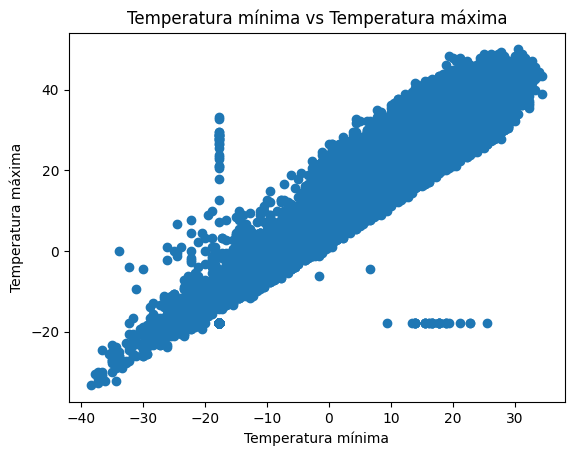

In [ ]:
#Visualizamos las variables para buscar patrones
plt.scatter(x=Data['MinTemp'], y=Data['MaxTemp'])
plt.title('Temperatura mínima vs Temperatura máxima')
plt.xlabel('Temperatura mínima')
plt.ylabel('Temperatura máxima')
plt.show()

In [ ]:
#Separamos nuestra datset en training y testing. Optaremos por hacerlo de forma aleatoria pero asegurando reproductibilidad.
rng = np.random.RandomState(42)

n = 100000   #Tamaño de subset (se eligió como predeterminado tres cuartas partes de training)
num = rng.randint(1, N+1, size=int(n))
num

array([ 15796,    861, 103695, ...,  21391,  88828,  51452])

In [ ]:
#Creamos nuestro subset de entrenamiento
Train_Data = Data[['MinTemp','MaxTemp']].iloc[num]
Train_Data.head()


,MinTemp,MaxTemp
15796,20.555556,31.666667
861,23.888889,32.777778
103695,25.000000,28.888889
110269,24.444444,30.555556
76821,17.777778,28.888889


In [ ]:
# restante = Data[['MinTemp','MaxTemp']].index.difference(num)
Test_Data = Data[['MinTemp','MaxTemp']].drop(num)
Test_Data['MinTemp'].tolist()

[22.22222222,
 21.66666667,
 21.66666667,
 21.66666667,
 21.66666667,
 22.22222222,
 21.66666667,
 19.44444444,
 19.44444444,
 20.55555556,
 21.11111111,
 21.11111111,
 21.66666667,
 21.66666667,
 20.55555556,
 17.77777778,
 20.55555556,
 20.55555556,
 20.0,
 21.11111111,
 22.22222222,
 21.11111111,
 22.77777778,
 22.22222222,
 21.11111111,
 20.55555556,
 22.22222222,
 22.22222222,
 23.33333333,
 22.22222222,
 22.77777778,
 20.55555556,
 21.11111111,
 21.11111111,
 22.77777778,
 22.22222222,
 22.22222222,
 22.22222222,
 21.66666667,
 22.22222222,
 22.22222222,
 22.22222222,
 21.11111111,
 21.66666667,
 20.55555556,
 23.33333333,
 22.22222222,
 22.22222222,
 23.33333333,
 22.77777778,
 22.77777778,
 22.77777778,
 22.77777778,
 23.33333333,
 22.77777778,
 22.77777778,
 23.33333333,
 22.22222222,
 21.66666667,
 22.77777778,
 23.33333333,
 22.22222222,
 21.66666667,
 20.0,
 20.55555556,
 22.77777778,
 22.77777778,
 18.88888889,
 22.22222222,
 18.88888889,
 16.11111111,
 16.66666667,
 22.22

Se definen las funciones autilizar.

Recordemos que estamos tratando con un problema de regresión lineal, por lo que la función de hipótesis será:

$Y = wX + b$

Recordemos que la función de costo es una medida que cuantifica cuán bien se ajusta el modelo a los datos de entrenamiento. Es decir, esta función evalúa la discrepancia entre las predicciones del modelo y los valores reales del subset de entrenamiento.
Aunado a que es una relación lineal, la función de costo será:

MSE = $\frac{1}{N}∑(y_i-f-{w,b}(x_i))^2$

El Gradiente Descendiente es un método de optimización para encontrar los parámetros óptimos de un modelo al minimizar la función de costo. Por ello, se definen las correspondientes derivadas dentro de la función **update_w_and_b**

In [ ]:
#Esta función contiene la esencia del algoritmo del gradiente descendiente. Aqui la función actualiza los valores de w (pendiente) y b (intercepción) para una regresión lineal utilizando
#el gradiente descendiente.
def update_w_and_b(X, y, w, b, alpha):
  '''Update parameters w and b during 1 epoch'''
  dl_dw = 0.0
  dl_db = 0.0
  N = len(X)
  for i in range(N):
    dl_dw += -2*X[i]*(y[i] - (w*X[i] + b))
    dl_db += -2*(y[i] - (w*X[i] + b))
  # update w and b
  w = w - (1/float(N))*dl_dw*alpha
  b = b - (1/float(N))*dl_db*alpha
  return w, b

#Esta función registra el progreso y la perdida del modelo. En cada epoch se actualizan los valores de w y b utilizando el gradiente descendiente y se calculan los errores. Esto se
#hace para un set de entrenamiento
def train(X, y, w, b, alpha, epochs):
  '''Loops over multiple epochs and prints progress'''
  print('Training progress:')
  for e in range(epochs):
    w, b = update_w_and_b(X, y, w, b, alpha)
  # log the progress
    if e % 400 == 0:
      avg_loss_ = avg_loss(X, y, w, b)
      # print("epoch: {} | loss: {}".format(e, avg_loss_))
      print("Epoch {} | Loss: {} | w:{}, b:{}".format(e, avg_loss_, round(w, 4), round(b, 4)))
  return w, b

def train_and_plot(X, y, w, b, alpha, epochs):
  '''Loops over multiple epochs and plot graphs showing progress'''
  for e in range(epochs):
    w, b = update_w_and_b(X, y, w, b, alpha)
  # plot visuals for last epoch
    if e == epochs-1:
      avg_loss_ = avg_loss(X, y, w, b)
      lim_inf = int(np.ceil(min(Data['MinTemp'])))   #Utilizamos el mínimo de la data original para hacer el plot más general
      lim_sup = int(np.ceil(max(Data['MinTemp'])))
      x_list = np.array(range(lim_inf,lim_sup))   # Ajustamos el tamaño para que cuente los valores negativos
      y_list = (x_list * w) + b # Set function for the model based on w & b
      plt.scatter(x=X, y=y)
      plt.plot(x_list,y_list, c='r')
      plt.title("Epoch {} | Loss: {} | w:{}, b:{}".format(e, round(avg_loss_,2), round(w, 4), round(b, 4)))
      plt.show()
  return w, b

def avg_loss(X, y, w, b):
  '''Calculates the MSE'''
  N = len(X)
  total_error = 0.0
  for i in range(N):
    total_error += (y[i] - (w*X[i] + b))**2
  return total_error / float(N)

def predict(x, w, b):
  return w*x + b

In [ ]:
# Define initial w and b, learning rate alpha and number of epochs e, to train
# the model using features X and labels y
w = 0.0
b = 0.0
alpha = 0.001  #Tasa de aprendizaje: Número de pasos que se dan en dirección del gradiente
epochs = 12000
# Train Model
X = Train_Data['MinTemp'].tolist()
y = Train_Data['MaxTemp'].tolist()
w, b = train(X, y, w, b, alpha, epochs)

Training progress:
Epoch 0 | Loss: 77.10317465055572 | w:1.0895, b:0.0541
Epoch 400 | Loss: 32.56507677547532 | w:1.3431, b:1.4888
Epoch 800 | Loss: 28.76650298568516 | w:1.2864, b:2.7192
Epoch 1200 | Loss: 25.914785711075805 | w:1.2372, b:3.7853
Epoch 1600 | Loss: 23.7739055112066 | w:1.1946, b:4.709
Epoch 2000 | Loss: 22.16667464333947 | w:1.1577, b:5.5094
Epoch 2400 | Loss: 20.960072301559094 | w:1.1257, b:6.2028
Epoch 2800 | Loss: 20.05423528691864 | w:1.098, b:6.8037
Epoch 3200 | Loss: 19.374192932712972 | w:1.0739, b:7.3243
Epoch 3600 | Loss: 18.86366223454471 | w:1.0531, b:7.7753
Epoch 4000 | Loss: 18.480389645475817 | w:1.0351, b:8.1662
Epoch 4400 | Loss: 18.192654004780714 | w:1.0195, b:8.5048
Epoch 4800 | Loss: 17.97664116877563 | w:1.0059, b:8.7982
Epoch 5200 | Loss: 17.81447305778434 | w:0.9942, b:9.0524
Epoch 5600 | Loss: 17.69272799526616 | w:0.9841, b:9.2727
Epoch 6000 | Loss: 17.601329876631524 | w:0.9753, b:9.4636
Epoch 6400 | Loss: 17.53271423081685 | w:0.9676, b:9.62

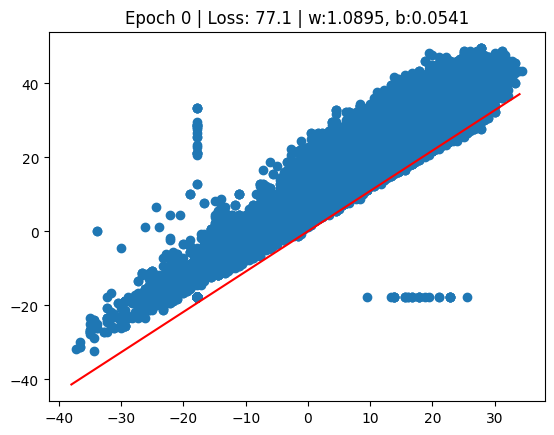

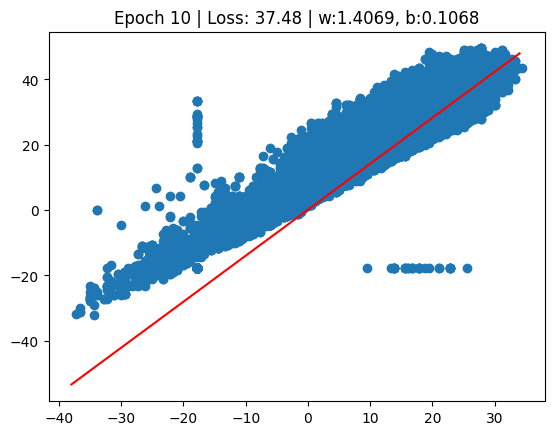

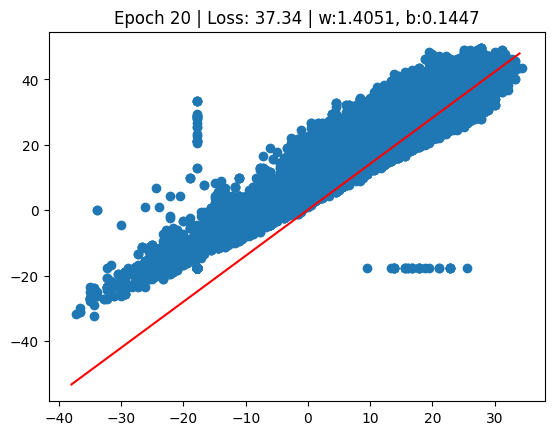

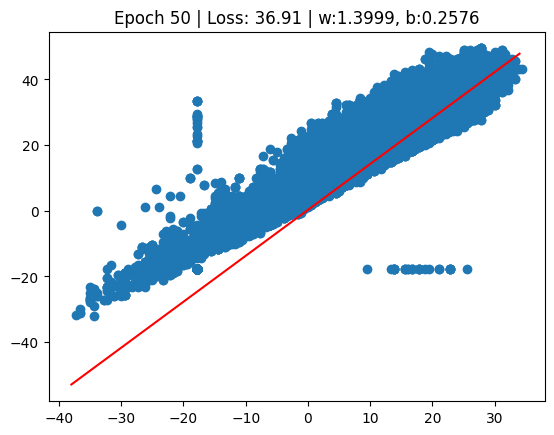

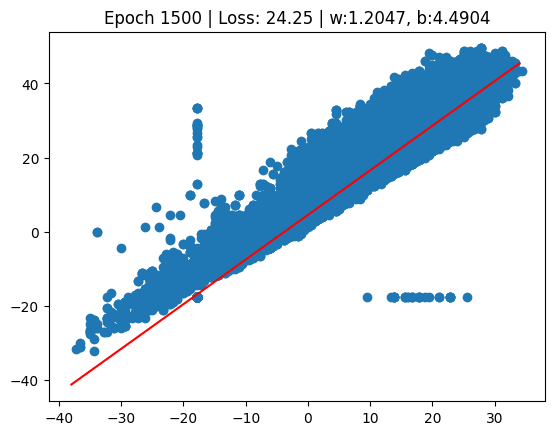

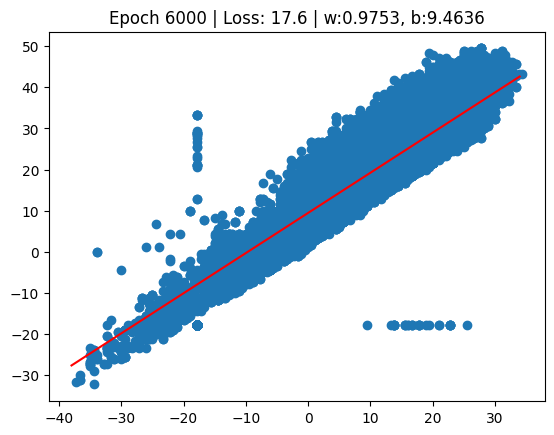

In [ ]:
# Define epoch numbers to plot to visualize progress
X = Train_Data['MinTemp'].tolist()
y = Train_Data['MaxTemp'].tolist()
epoch_plots = [1, 11, 21, 51, 1501, 6001]
for epoch_plt in epoch_plots:
  w, b = train_and_plot(X, y, 0.0, 0.0, alpha, epoch_plt)

De los gráficos anteriores es posible observarse cómo el ajuste de la línea va mejorando conforme cada iteración (epoch)...

## Algunas predicciones:

Para ello utilizamos el subset de testing que creamos:

In [ ]:
Test_Data['MinTemp']
Test_Data.head(10)

,MinTemp,MaxTemp
0,22.222222,25.555556
1,21.666667,28.888889
4,21.666667,26.666667
5,21.666667,26.666667
9,21.666667,25.555556
13,22.222222,26.111111
18,21.666667,27.777778
24,19.444444,27.222222
25,19.444444,25.555556
32,20.555556,24.444444


Para x=22.22222222, la predicción de y es y=31.1087 siendo la verdadera 25.5556
Para x=21.66666667, la predicción de y es y=30.5944 siendo la verdadera 28.8889
Para x=19.44444444, la predicción de y es y=28.5371 siendo la verdadera 27.2222
Para x=20.55555556, la predicción de y es y=29.5657 siendo la verdadera 24.4444


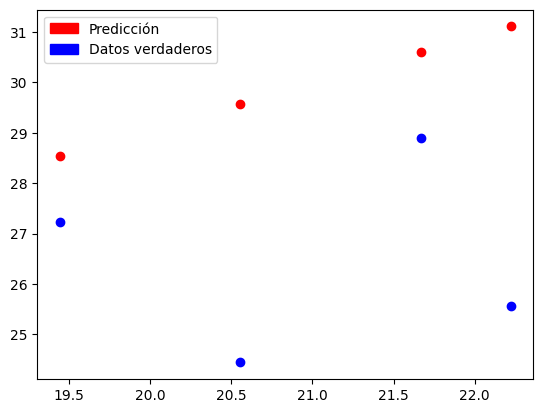

In [ ]:
import matplotlib.patches as mpatches
#Veamos donde caen las predicciones contra los valores reales
#Utilizamos los parámetrso calculados en la iteración epoch = 11600:
w_11600 = 0.9258
b_11600 = 10.5354
nn = 5
x_new = [0, 1, 24, 32]

# Crear elementos de leyenda para "Predicción" y "Datos verdaderos"
legend_prediccion = mpatches.Patch(color='r', label='Predicción')
legend_verdaderos = mpatches.Patch(color='b', label='Datos verdaderos')

for i in x_new:
  x_new = Test_Data['MinTemp'][i]
  y_new = predict(x_new, w_11600, b_11600)
  plt.scatter(x=x_new,y=Test_Data['MaxTemp'][i], c='b')
  plt.scatter(x=x_new,y=y_new, c='r')
  print('Para x={}, la predicción de y es y={} siendo la verdadera {}'.format(x_new, round(y_new,4), round(Test_Data['MaxTemp'][i],4)))

plt.legend(handles=[legend_prediccion, legend_verdaderos], loc='upper left')
plt.show()


#Se necesitaría comparar con más puntos y revisar la base de datos de testing para revisar que no haya fallas internas

## ¿Qué tal es el rendimiento del modelo?
Según como vimos en los gráficos iterativos de algunas epoch, el MSE se estabiliza en un valor de 17.6 por lo que, según el contexto del problema, las predicciones generales del modelo se ajustan bastante bien.

De hecho, el error promedio de MSE se nota en mayor medida en la última gráfica donde se muestran pequeñas diferencias entre los valores predictivos por el modelo y los valores reales.



# **Conclusiones**
En el presente trabajo se aplicó un algoritmo de regresión lineal para anilizar la relación entre dos variables numéricas: la temp máxima y temp mínima de un cierto lugar medida años atrás. El análisis permitió conocer el patrón lineal entre las variables tras ajustar una pendiente con un error mínimo según loo visto anteriormente. Se demostró el funcionamiento de la regresión lineal junto con la optimización utilizando el gradiente descendiente.

Adicionalmente a lo anterior es importante resaltar que la aplicación de la regresión lineal no solo brinda la oportunidad de hacer predicciones, sino que también actúa como una herramienta educativa y de comprensión. Al utilizar este algoritmo base del machine learning, se logra una visión más profunda de cómo las variables interactúan entre sí y cómo influyen en un resultado específico. A medida que se experimenta con diferentes conjuntos de datos y se ajustan los parámetros del modelo, se gana intuición sobre la naturaleza de las relaciones lineales y sus efectos en los resultados. En última instancia, el uso de la regresión lineal y algoritmos similares no solo facilita la toma de decisiones basadas en datos, sino que también enriquece la comprensión de las relaciones complejas en el mundo que nos rodea.

Dentro de un algoritmo de regresión lineal, el hecho de que el algoritmo aprenda es la consecuencia directa de un proceso de optimización para reducir el error entre el valor predicho y el verdadero. Tras ajustar ese error iterativamente, gracias al gradiente descendiente, el modelo se va a cercando cada vez más al valor del parámetros de la recta lineal que más se ajusta (la de mínimo MSE). Este proceso lo hace con los valores de entrada (X) y sus respectivos valores (Y) para "aprender" (o mejor dicho optimizar) y encontrar el patrón oculto detras de la distribución de ese dataset que , en este caso, el patrón que se buscó fue un patrón lineal (de regresión lineal).
